In [171]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn, optim
from torch. optim.lr_scheduler import ExponentialLR
from tqdm import tqdm


In [ ]:
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

batch_size = 4000
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [173]:
print(len(train_dataset))

60000


In [174]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_size = 16
        self.encoder = nn.Sequential(
            nn.Conv2d(1,2,(3,3), (2,2)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(338, 250),
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.Linear(250, self.latent_size)
        )
        self.log_var = nn.Sequential(
            nn.Linear(250, self.latent_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size, 784),
            nn.Unflatten(1, torch.Size([4, 14, 14])),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, (4,4),(2,2), padding = 1),
            nn.Sigmoid()
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        x = self.reparameterize(mu, log_var)
        x = self.decoder(x)
        return x, mu, log_var

In [175]:
model = Net()
model.to("cuda")

Net(
  (encoder): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=338, out_features=250, bias=True)
    (4): ReLU()
  )
  (mu): Sequential(
    (0): Linear(in_features=250, out_features=16, bias=True)
  )
  (log_var): Sequential(
    (0): Linear(in_features=250, out_features=16, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=784, bias=True)
    (1): Unflatten(dim=1, unflattened_size=torch.Size([4, 14, 14]))
    (2): ReLU()
    (3): ConvTranspose2d(4, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [176]:
def loss_f(output, target, mu, log_var):
    BCE = nn.BCELoss(reduction='sum')(output, target)
    KLD = 0.5 * torch.sum(mu**2 + torch.exp(log_var) -1 - log_var)
    return BCE + KLD 

In [180]:
optimizer = optim.Adam(model.parameters(), lr = 0.0005)
scheduler = ExponentialLR(optimizer, gamma=0.995)
cuda0 = torch.device('cuda:0')

train_loss_list = []
test_loss_list = []

for epoch in tqdm(range(1000)):
    optimizer.zero_grad()
    for x_train, y_train in train_loader:
        x_train = x_train.cuda()
        outputs, mu, log_var = model(x_train)
        loss = loss_f(outputs, x_train, mu, log_var)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
        for x_test, y_test in test_loader:
            x_test = x_test.cuda()
            outputs, mu, log_var = model(x_test)
            test_loss = loss_f(outputs, x_test, mu, log_var)
        print("Epoch:", epoch + 1, "Train_Loss:", loss.item(), "Test_Loss:", test_loss.item(), "Learning_Rate:", scheduler.optimizer.param_groups[0]['lr'])
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())

  2%|▎         | 10/400 [00:19<13:16,  2.04s/it]

Epoch: 10 Train_Loss: 653070.625 Test_Loss: 333348.5 Learning_Rate: 0.00047555506523288594


  5%|▌         | 20/400 [00:42<17:18,  2.73s/it]

Epoch: 20 Train_Loss: 645020.875 Test_Loss: 329804.71875 Learning_Rate: 0.00045230524013730876


  8%|▊         | 30/400 [01:04<13:04,  2.12s/it]

Epoch: 30 Train_Loss: 636480.8125 Test_Loss: 327796.21875 Learning_Rate: 0.00043019209595734806


 10%|█         | 40/400 [01:24<12:22,  2.06s/it]

Epoch: 40 Train_Loss: 634380.5 Test_Loss: 324478.9375 Learning_Rate: 0.00040916006051133714


 12%|█▎        | 50/400 [01:44<12:12,  2.09s/it]

Epoch: 50 Train_Loss: 628239.1875 Test_Loss: 321523.6875 Learning_Rate: 0.00038915627853432097


 15%|█▌        | 60/400 [02:04<11:38,  2.05s/it]

Epoch: 60 Train_Loss: 627827.9375 Test_Loss: 320516.34375 Learning_Rate: 0.0003701304788483523


 18%|█▊        | 70/400 [02:26<13:00,  2.36s/it]

Epoch: 70 Train_Loss: 618389.125 Test_Loss: 316470.40625 Learning_Rate: 0.0003520348480268149


 20%|██        | 80/400 [02:51<14:01,  2.63s/it]

Epoch: 80 Train_Loss: 621071.5 Test_Loss: 316024.03125 Learning_Rate: 0.00033482391023528216


 22%|██▎       | 90/400 [03:17<13:53,  2.69s/it]

Epoch: 90 Train_Loss: 615000.125 Test_Loss: 313500.84375 Learning_Rate: 0.00031845441294693904


 25%|██▌       | 100/400 [03:39<10:34,  2.11s/it]

Epoch: 100 Train_Loss: 610412.625 Test_Loss: 311156.4375 Learning_Rate: 0.0003028852182453639


 28%|██▊       | 110/400 [03:58<09:53,  2.05s/it]

Epoch: 110 Train_Loss: 607326.6875 Test_Loss: 309659.59375 Learning_Rate: 0.00028807719944150197


 30%|███       | 120/400 [04:18<09:24,  2.02s/it]

Epoch: 120 Train_Loss: 601336.9375 Test_Loss: 308227.5 Learning_Rate: 0.00027399314274502103


 32%|███▎      | 130/400 [04:38<09:06,  2.02s/it]

Epoch: 130 Train_Loss: 602516.375 Test_Loss: 308122.28125 Learning_Rate: 0.00026059765374294373


 35%|███▌      | 140/400 [04:57<08:39,  2.00s/it]

Epoch: 140 Train_Loss: 600492.0 Test_Loss: 305586.09375 Learning_Rate: 0.0002478570684505253


 38%|███▊      | 150/400 [05:17<08:30,  2.04s/it]

Epoch: 150 Train_Loss: 603382.875 Test_Loss: 304754.0625 Learning_Rate: 0.00023573936871084284


 40%|████      | 160/400 [05:36<08:08,  2.04s/it]

Epoch: 160 Train_Loss: 599281.125 Test_Loss: 304922.15625 Learning_Rate: 0.0002242141017304884


 42%|████▎     | 170/400 [05:56<07:52,  2.05s/it]

Epoch: 170 Train_Loss: 596073.625 Test_Loss: 303367.625 Learning_Rate: 0.00021325230354915067


 45%|████▌     | 180/400 [06:16<07:32,  2.06s/it]

Epoch: 180 Train_Loss: 590811.75 Test_Loss: 301916.6875 Learning_Rate: 0.0002028264262507591


 48%|████▊     | 190/400 [06:36<07:10,  2.05s/it]

Epoch: 190 Train_Loss: 588766.625 Test_Loss: 301451.21875 Learning_Rate: 0.00019291026873326572


 50%|█████     | 200/400 [06:55<06:48,  2.04s/it]

Epoch: 200 Train_Loss: 589602.9375 Test_Loss: 298968.90625 Learning_Rate: 0.0001834789108630835


 52%|█████▎    | 210/400 [07:15<06:41,  2.11s/it]

Epoch: 210 Train_Loss: 586129.375 Test_Loss: 300745.875 Learning_Rate: 0.00017450865084870507


 55%|█████▌    | 220/400 [07:37<06:32,  2.18s/it]

Epoch: 220 Train_Loss: 585924.875 Test_Loss: 298955.375 Learning_Rate: 0.0001659769456761177


 57%|█████▊    | 230/400 [07:58<06:13,  2.20s/it]

Epoch: 230 Train_Loss: 587888.375 Test_Loss: 298685.9375 Learning_Rate: 0.00015786235445632262


 60%|██████    | 240/400 [08:18<05:28,  2.05s/it]

Epoch: 240 Train_Loss: 583892.6875 Test_Loss: 297999.8125 Learning_Rate: 0.0001501444845425869


 62%|██████▎   | 250/400 [08:38<05:07,  2.05s/it]

Epoch: 250 Train_Loss: 588406.4375 Test_Loss: 296768.0 Learning_Rate: 0.0001428039402820159


 65%|██████▌   | 260/400 [08:58<04:47,  2.05s/it]

Epoch: 260 Train_Loss: 584387.3125 Test_Loss: 297320.28125 Learning_Rate: 0.0001358222742726544


 68%|██████▊   | 270/400 [09:18<04:27,  2.06s/it]

Epoch: 270 Train_Loss: 583795.6875 Test_Loss: 296594.4375 Learning_Rate: 0.0001291819410036222


 70%|███████   | 280/400 [09:38<04:08,  2.07s/it]

Epoch: 280 Train_Loss: 585016.375 Test_Loss: 296694.875 Learning_Rate: 0.00012286625276177672


 72%|███████▎  | 290/400 [09:57<03:43,  2.03s/it]

Epoch: 290 Train_Loss: 581399.75 Test_Loss: 296819.78125 Learning_Rate: 0.00011685933769409395


 75%|███████▌  | 300/400 [10:17<03:25,  2.05s/it]

Epoch: 300 Train_Loss: 578740.25 Test_Loss: 296402.84375 Learning_Rate: 0.00011114609992037339


 78%|███████▊  | 310/400 [10:37<03:02,  2.03s/it]

Epoch: 310 Train_Loss: 578528.5 Test_Loss: 294793.5625 Learning_Rate: 0.00010571218159602804


 80%|████████  | 320/400 [10:56<02:40,  2.01s/it]

Epoch: 320 Train_Loss: 579040.8125 Test_Loss: 295770.25 Learning_Rate: 0.0001005439268296196


 82%|████████▎ | 330/400 [11:15<02:23,  2.04s/it]

Epoch: 330 Train_Loss: 583197.6875 Test_Loss: 295185.375 Learning_Rate: 9.562834736446053e-05


 85%|████████▌ | 340/400 [11:36<02:09,  2.16s/it]

Epoch: 340 Train_Loss: 577384.5625 Test_Loss: 295956.75 Learning_Rate: 9.09530899380382e-05


 88%|████████▊ | 350/400 [11:57<01:48,  2.17s/it]

Epoch: 350 Train_Loss: 574584.9375 Test_Loss: 293064.6875 Learning_Rate: 8.650640523723257e-05


 90%|█████████ | 360/400 [12:18<01:27,  2.19s/it]

Epoch: 360 Train_Loss: 577829.0 Test_Loss: 294777.1875 Learning_Rate: 8.227711837130919e-05


 92%|█████████▎| 370/400 [12:40<01:05,  2.20s/it]

Epoch: 370 Train_Loss: 574973.875 Test_Loss: 295297.09375 Learning_Rate: 7.825460078848366e-05


 95%|█████████▌| 380/400 [13:00<00:42,  2.13s/it]

Epoch: 380 Train_Loss: 577539.1875 Test_Loss: 293963.9375 Learning_Rate: 7.442874356548158e-05


 98%|█████████▊| 390/400 [13:21<00:21,  2.18s/it]

Epoch: 390 Train_Loss: 581608.8125 Test_Loss: 294187.25 Learning_Rate: 7.078993200296866e-05


100%|██████████| 400/400 [13:48<00:00,  2.07s/it]

Epoch: 400 Train_Loss: 577757.625 Test_Loss: 293315.375 Learning_Rate: 6.732902146300664e-05


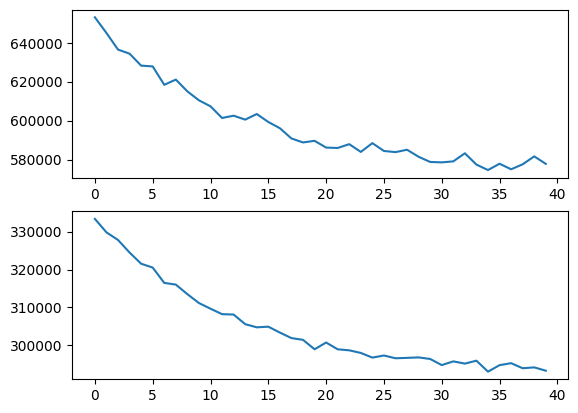

In [181]:
fig, ax = plt.subplots(2)
ax[0].plot(train_loss_list)
ax[1].plot(test_loss_list)

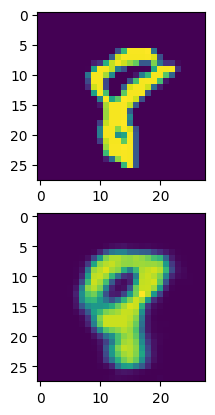

In [191]:
fig, ax = plt.subplots(2)
torch.no_grad()
x_train, y_train = next(iter(train_loader))
x_train = x_train.cuda()
outputs, mu, log_var = model(x_train)
outputs = outputs.cpu().detach().numpy()
ax[0].imshow(x_train.cpu()[0,0])
ax[1].imshow(outputs[0,0])

In [192]:
import pickle
with open('checkpoint2.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)